<a href="https://colab.research.google.com/github/Jan-Agatz/MML-Paper-03/blob/main/MML_Paper_03_Calculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Necessary libraries

In [ ]:
# If scholarly or NetworkX are not installed, manually install them
!pip install scholarly
!pip install NetworkX
!pip install levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.5 MB/s eta 0:00:00


In [ ]:
# Getting the data
import json
from scholarly import scholarly
from scholarly import ProxyGenerator

# For cleaning the text data
from Levenshtein import distance
import copy

# Useful for calculations and visualizations
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Setup

In [ ]:
verbosity = 1

## Getting the data

In [ ]:
authors = ["Chiyuan Zhang", "Samy Bengio", "Moritz Hardt", "Benjamin Recht", "Oriol Vinyals"]

number_of_authors = len(authors)

# Found in the URL of the corresponding Google Scholar Profile Pages
author_ids = {
    "Chiyuan Zhang"  : "l_G2vr0AAAAJ",
    "Samy Bengio"    : "Vs-MdPcAAAAJ",
    "Moritz Hardt"   : "adnTgaAAAAAJ",
    "Benjamin Recht" : "a_dbdxAAAAAJ",
    "Oriol Vinyals"  : "NkzyCvUAAAAJ"
}

In [ ]:
# Only run, if the object author_information does not yet exist
# Otherwise important data will be overwritten

author_information = {}
already_downloaded = {}

for name in authors:
  already_downloaded[name] = False

In [ ]:
# Since we use free proxies this might take a while (~1 minute to ~10 minutes)
for name in author_ids:

  if verbosity >= 1:
    print(name)
    print("-------------------------------------------------------------------")

  # Since Juypter Notebook/Google Colabs saves variables, we don't have to rerun
  # known queries; this saves time
  if already_downloaded[name]:

    if verbosity >= 1:
      print("Already downloaded")
      scholarly.pprint(author_information[name])
      print("-------------------------------------------------------------------")

    continue

  # Create a proxy using scholarly in order to not get banned from Google Scholar
  # Changing proxies every request seems to work best
  pg = ProxyGenerator()
  success = pg.FreeProxies()
  scholarly.use_proxy(pg)

  # Fetch the information
  id = author_ids[name]
  author = scholarly.search_author_id(id)
  author_more_information = scholarly.fill(author, sections = ["publications"])

  # Save it
  author_information[name] = author_more_information
  already_downloaded[name] = True

  if verbosity >= 1:
      print("Downloaded")
      scholarly.pprint(author_more_information)
      print("-------------------------------------------------------------------")

Chiyuan Zhang
-------------------------------------------------------------------
Already downloaded
b"{'affiliation': 'Google Research',\n 'citedby': 16855,\n 'email_domain': '@google.com',\n 'filled': False,\n 'homepage': 'http://pluskid.org/',\n 'interests': ['Machine Learning', 'Computational Neuroscience'],\n 'name': 'Chiyuan Zhang',\n 'organization': 6518679690484165796,\n 'publications': [{'author_pub_id': 'l_G2vr0AAAAJ:L_l9e5I586QC',\n                   'bib': {'citation': 'Communications of the ACM 64 (3), '\n                                       '107-115, 2021',\n                           'pub_year': '2021',\n                           'title': 'Understanding deep learning (still) '\n                                    'requires rethinking generalization'},\n                   'citedby_url': 'https://scholar.google.com/scholar?oi=bibs&hl=en&cites=12269741163621005853,15896457662245400235,3263762468897561873,12828698334185718087',\n                   'cites_id': ['1226974116

## Ordering and cleaning the data

In [ ]:
# Take a look at the data
if verbosity >= 2:
  print(author_information)

In [ ]:
title_names = {}
titles = []

for author in authors:
  publications = author_information[author]["publications"]

  for publication in publications:
    title = publication['bib']['title']

    if verbosity >= 2:
      print(title)

    # The title has already been enter, so there exist a coauthor
    if title in title_names:

      # Some authors have the same paper several times, leading to overcounting
      already_included = False
      for current_name in title_names[title]:
        if current_name == author:
          already_included = True
          break

      if not already_included:
        title_names[title].append(author)
    else:
      title_names[title] = [author]
      titles.append(title)

In [ ]:
# Order the titles alphabetically
titles.sort()

# Then compare Levenshtein distances
window_width = 10
max_levenshtein_distance = 30 # has to be fine-tuned

max_length = len(titles)

for index, first_title in enumerate(titles):
    for offset_index in range(index + 1, min(index + window_width + 1, max_length)):
      second_title = titles[offset_index]
      current_levenshtein_distance = distance(first_title, second_title, score_cutoff = max_levenshtein_distance)

      if current_levenshtein_distance <= max_levenshtein_distance:
        print(f"{index}: {first_title}")
        print(f"{offset_index}: {second_title}")
        print(f"Distance: {current_levenshtein_distance}")
        print("--------------------------------------------------------------")

2: 2004 Index IEEE Transactions on Pattern Analysis and Machine Intelligence Vol. 26
3: 2009 Index IEEE Transactions on Pattern Analysis and Machine Intelligence Vol. 31
Distance: 3
--------------------------------------------------------------
2: 2004 Index IEEE Transactions on Pattern Analysis and Machine Intelligence Vol. 26
4: 2013 Index IEEE Transactions on Pattern Analysis and Machine Intelligence Vol. 35
Distance: 4
--------------------------------------------------------------
3: 2009 Index IEEE Transactions on Pattern Analysis and Machine Intelligence Vol. 31
4: 2013 Index IEEE Transactions on Pattern Analysis and Machine Intelligence Vol. 35
Distance: 3
--------------------------------------------------------------
7: A Kernel Classifier for Distributions
10: A Probabilistic Model for Chord Progressions
Distance: 28
--------------------------------------------------------------
7: A Kernel Classifier for Distributions
17: A distance model for rhythms
Distance: 26
------------

In [ ]:
# We now merge different versions of the same paper

# To get the list of lists of corresponding indices you have to go through the
# above list manually (or maybe use a LLM; I did not test that)

merges = [
    (58,59),
    (114,115),
    (143,144),
    (220,221),
    (244,246),
    (250,251,252),
    (341,342,343,344),
    (497,498),
    (547,548),
    (687,688),
    (690,691),
    (692,693),
    (751,752),
    (793,794),
    (853,858,859),
    (867,868),
    (869,870),
    (881,882,883,884,885),
    (913,914,915,916),
    (938,939)
]

# Rechecking

print("Rechecking")
for merge in merges:
  for index in merge:
    print(titles[index])

  print("----------------------------------------------------")

# Actual merging
# In order to redo mistakes we create a new  dictionary with merged authors
title_merged_names = copy.deepcopy(title_names) #NOT THREAD SAFE

for merge in merges:
  # We merge into the first index:
  first_index = merge[0]
  first_title = titles[first_index]
  merged_authors = title_merged_names[first_title]

  if verbosity >= 1:
    print(merged_authors)

  for index in merge:
    # Sentinal; as we do not want to merge an index weith itself
    if index == first_index:
      continue

    current_title = titles[index]
    additional_authors = title_names[current_title]

    if verbosity >= 1:
      print(additional_authors)

    # Actual merge

    for additional_author in additional_authors:
      if not additional_author in merged_authors:
        merged_authors.append(additional_author)

    title_merged_names[first_title] = merged_authors

    # Deleting the useless titles (and thus avoid overcounting)
    title_merged_names.pop(current_title, None)

  if verbosity >= 1:
      print("--------------------------------------------------------")

Rechecking
A study on overfitting in deep reinforcement learning
A study on overfitting in deep reinforcement learning. arXiv 2018
----------------------------------------------------
Aspects th eoriques de l'optimisation d'une r egle d'apprentissage
Aspects theoriques de l'optimisation d'une regle d'apprentissage
----------------------------------------------------
Bayesian recurrent neural networks
Bayesian recurrent neural networks. arXiv preprint 2017
----------------------------------------------------
Deduplicating Training Data Makes Language Models Better
Deduplicating training data makes language models better
----------------------------------------------------
Discriminative Keyword Spotting
Discriminative keyword spotting
----------------------------------------------------
Distilling the knowledge in a neural network
Distilling the knowledge in a neural network [EB/OL]
Distilling theknowledge in a neural network
----------------------------------------------------
Google's

## Analysis

In [ ]:
coauthor_matrix        = np.zeros((number_of_authors, number_of_authors))
coauthor_count_exact   = np.zeros(number_of_authors)
coauthor_count_greater = np.zeros(number_of_authors)

for title in title_merged_names:
  coauthors = title_merged_names[title]

  coauthor_count_exact[len(coauthors) - 1] += 1

  for author in coauthors:
    for coauthor in coauthors:
      index_author   = authors.index(author)
      index_coauthor = authors.index(coauthor)

      coauthor_matrix[index_author, index_coauthor] += 1


coauthor_count_greater[-1] = coauthor_count_exact[-1]
for i in range(number_of_authors - 2, -1, -1):
  coauthor_count_greater[i] = coauthor_count_exact[i] + coauthor_count_greater[i + 1]

In [ ]:
# Print the results
print(f"Coauthor matrix: {coauthor_matrix})
print(f"Coauthor count (==): {coauthor_count_exact})
print(f"Coauthor count (>=): {coauthor_count_greater})

[[ 63.   7.   2.   1.   2.]
 [  7. 413.   2.   1.  10.]
 [  2.   2.  89.   7.   1.]
 [  1.   1.   7. 194.   1.]
 [  2.  10.   1.   1. 188.]]
[900.  18.   2.   0.   1.]
[921.  21.   3.   1.   1.]


## Visualizations

In [ ]:
# Defining the graph
G = nx.Graph()

for author in authors:
  G.add_node(author)

for index in range(0, number_of_authors):
  for coindex in range(0, number_of_authors):
    # Sentinal
    if index == coindex:
      continue

    G.add_edge(authors[index], authors[coindex], weight = coauthor_matrix[index, coindex])

print(G)

Graph with 5 nodes and 10 edges


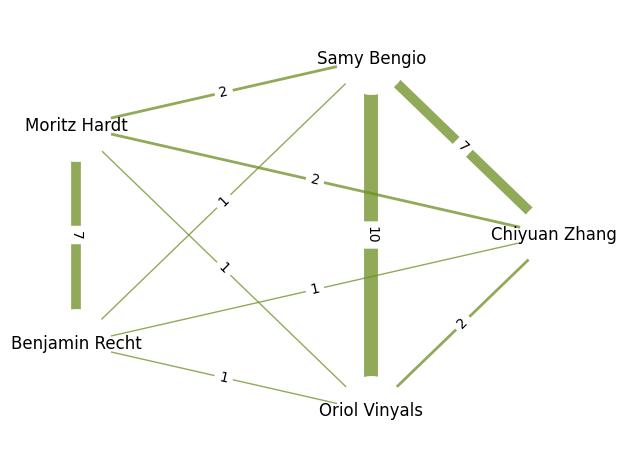

In [ ]:
# Drawing the graph

# Calculate the node positions
seed = 15
pos = nx.circular_layout(G)

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size = 2500, node_color = "white")
# Draw the labels
nx.draw_networkx_labels(G, pos, font_size = 12, font_family = "sans-serif")
# Draw the edges
weights = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edges(G, pos, G.edges, width = list(weights.values()), edge_color = "olivedrab", alpha = 0.75)
# Draw the edges
weight_labels = copy.deepcopy(weights)
for current_edge in weight_labels:
  weight_labels[current_edge] = str(int(weight_labels[current_edge]))
nx.draw_networkx_edge_labels(G, pos, weight_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()